# Explore New Place
JUNSEONG LEE


## Introduction
When we are facing situations that we must make a decision in our life, like choosing our university or our first job, the machine learning algorithm can be a good adviser in our life. Some outcomes of choices will be an important decision in our whole life, some will not. 

I recognize that my most frequency situation of making a decision is picking my lunch menu every day. I have been worked 3 years in my last job, which is located in Gangnam, Seoul, South Korea, it means I had had lunch in Gangnam nearby the office at least 700 times. 

3 years, it’s enough to visit almost restaurants nearby the office. But why I’m still in the struggle for selecting lunch menu? This question is my project’s start point. I’m going to use a machine learning algorithm to make a recommender which can help me which restaurant is expected to be given a high rating by me.

In Gangnam-gu, there are subway stations in every intersection, so subway station will be a good landmark to find somewhere in Gangnam, for example, restaurants. There are 4 subway stations, Gangnam station, Yangjea station, Sinnonhyeon station, Yeoksam station, near my office, and I find that I never go to Yeoksam station to have my lunch. Even though Yeoksam station is the second nearest place except for Gangnam station from the office!

In this project, I will make an adviser, who predict ratings of restaurants nearby Yeoksam station, Then I can go to a new place to have my lunch with it. It will keep learning my tastes, not even nearby Yeoksam station, it can predict ratings of restaurants in which I heading to! 


In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import folium # map rendering library

In [6]:
# Location of Office
office_lat = 37.492133 
office_lng = 127.032527 

In [12]:
df_Station_Location = pd.DataFrame({
    'Station':['Yeoksam','Gangnam','Sinnonhyeon','Yangjea'],
    'Latitude':[37.500705,37.497921,37.504435,37.484536],
    'Longitude':[127.036880,127.027675,127.024537,127.034036]
})
df_Station_Location

,Station,Latitude,Longitude
0,Yeoksam,37.500705,127.036880
1,Gangnam,37.497921,127.027675
2,Sinnonhyeon,37.504435,127.024537
3,Yangjea,37.484536,127.034036


In [13]:
df_points = df_Station_Location
map_gangnam = folium.Map(location=[office_lat, office_lng], zoom_start=14)
# Mark 4 Subway Station nearby Ofiice
for lat, lng, borough in zip(df_points['Latitude'], df_points['Longitude'],
                            df_points['Station']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gangnam) 
# Mark Office  
folium.CircleMarker(
        [office_lat, office_lng],
        radius=6,
        popup='office',
        color='red',
        fill=False,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gangnam) 

map_gangnam

## Data 
In dataset for the machine learning algorithm, each row is information of the restaurant. I select distance from the office, price level, ratings by Foursquare users, the number of shared tips and photos by Foursquare users as features of my data. I used Foursquare API to collect data

Foursquare API will provide information about places including non-restaurant, so I need to do feature engineering to remove rows which is useless for this project. First, I drop the duplicated rows by place id, 285 rows remained. Second, I remove rows whose ‘categories’ is non-restaurant and like café or Bar where we will not go to have lunch. After these two steps, 173 restaurants’ data retained 

The feature ‘categories’ in the dataset is important information about restaurants, but it refines restaurants into too many types. For example, Janguh Restaurant category only has one place in the dataset, which actually can be in Seafood Restaurant category. For another, someplace is an American Restaurant, some are Sandwich Place, some are Taco Place, all of these only have less than 2 places in the same category. So I create ‘New_categories’ to turn 36 ‘categories’ into 9 ‘New_categories’ 

About information shared by Foursquare users, I find that many restaurants have more than 50 tips or photos shared. I think the number of shared tips and photos is very important for the decision, but too many tips are useless. Because when I’m searching for the lunch restaurant in office before lunchtime, I see many blog posts or youtube videos on the internet but no more than 30~40 contents. So I refine the number of shared tips and photos to 5 levels. 1st level means there are less than 5 tips that not enough to use for make decision, 5th level means there are more than 30 tips which can fully help to make a decision. Like the table below. 

As I mentioned before, this project’s purpose is to predict ratings of restaurants near Yeoksam station, so I need my ratings of restaurants near the office, Gangnam station, Sinnonhyeon station ,and Yangjea station. I do survey myself based on memos, Instagram, blog and more, add My rating to the dataset. What if there are restaurants which I never visited even near the office? I will keep it blank to predict, but fortunately, except for 44 restaurants near Yeoksam station, I had been all of the restaurants in dataset! Thanks to my curiosity about the new taste, 3 years was enough time to visit these 129 restaurants. 

Now, the dataset is ready, including information of restaurants ID, distance, categories, price, four square user rating, counts of shared tips and photos, and my rating. 


In [20]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup

In [18]:
CLIENT_ID = 'YMNNYPQZOJX4DRRLTUQ3L0WVFMWFYOTB10EKYKNJ2LFEXRKP' # your Foursquare ID
CLIENT_SECRET = 'QGDEG2QCFDXRDOE2Q1VXINOZG1P0T5RIKQB32USLXTA5ESEW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YMNNYPQZOJX4DRRLTUQ3L0WVFMWFYOTB10EKYKNJ2LFEXRKP
CLIENT_SECRET:QGDEG2QCFDXRDOE2Q1VXINOZG1P0T5RIKQB32USLXTA5ESEW


In [14]:
df_Location = pd.DataFrame({
    'Station':['Office','Yeoksam','Gangnam','Sinnonhyeon','Yangjea'],
    'Latitude':[office_lat,37.500705,37.497921,37.504435,37.484536],
    'Longitude':[office_lng,127.036880,127.027675,127.024537,127.034036]
})
df_Location

,Station,Latitude,Longitude
0,Office,37.492133,127.032527
1,Yeoksam,37.500705,127.036880
2,Gangnam,37.497921,127.027675
3,Sinnonhyeon,37.504435,127.024537
4,Yangjea,37.484536,127.034036


In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [35]:
col_names = ['name','categories','lat','lng','id','Station']
neighborhoods = pd.DataFrame(columns=col_names)
neighborhoods

,name,categories,lat,lng,id,Station


In [36]:
for station, latitude,longitude in zip(df_points.Station,
                                       df_points.Latitude,
                                       df_points.Longitude):
    # type your answer here
    LIMIT = 100 # limit of number of venues returned by Foursquare API

    radius = 500 # define radius

    # create URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT)

    results = requests.get(url).json()

    venues = results['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name','venue.categories', 'venue.location.lat', 'venue.location.lng','venue.id']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    
    nearby_venues['Station'] = station

    neighborhoods = neighborhoods.append(nearby_venues)

In [37]:
# Reset Index
neighborhoods.reset_index(drop=True,inplace=True)

In [38]:
neighborhoods.duplicated(['id']).sum()

16

In [42]:
neighborhoods = neighborhoods.drop_duplicates(['id'],keep='last')
neighborhoods.reset_index(drop=True,inplace=True)
neighborhoods.duplicated(['id']).sum()

0

In [44]:
neighborhoods.shape

(285, 6)

In [45]:
neighborhoods.head()

,name,categories,lat,lng,id,Station
0,LG Arts Center (LG아트센터),Performing Arts Venue,37.502202,127.037527,4b7bbb23f964a5203b6c2fe3,Yeoksam
1,BAGUETTE_K.,Bakery,37.499477,127.035740,56a341e8498ee1e857354a1c,Yeoksam
2,Cafe 413 Project (카페 413프로젝트),Café,37.502234,127.034537,57072dd5498e4f01d87fda9a,Yeoksam
3,불이아 (弗二我),Chinese Restaurant,37.502396,127.036219,52aa9d0111d25f79bea32b9d,Yeoksam
4,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam


In [46]:
neighborhoods.categories.unique()

array(['Performing Arts Venue', 'Bakery', 'Café', 'Chinese Restaurant',
       'BBQ Joint', 'Korean Restaurant', 'Burger Joint', 'IT Services',
       'Coffee Shop', 'Gym / Fitness Center', 'Sandwich Place',
       'Japanese Restaurant', 'Hotel', 'Udon Restaurant', 'Salad Place',
       'Lawyer', 'Soba Restaurant', 'Seafood Restaurant',
       'Sushi Restaurant', 'Italian Restaurant', 'Sake Bar', 'Food Truck',
       'Restaurant', 'Spa', 'Mexican Restaurant', 'Tea Room',
       'Steakhouse', 'Gym', 'Breakfast Spot', 'Vietnamese Restaurant',
       'Dessert Shop', 'Bubble Tea Shop', 'Electronics Store',
       'Cocktail Bar', 'Noodle House', 'Toy / Game Store', 'Food Court',
       'Wine Bar', 'Rental Service', 'Pub', 'Rock Club', 'Pizza Place',
       'Golf Course', 'Cosmetics Shop', 'Dumpling Restaurant',
       'Fast Food Restaurant', 'Snack Place', 'Fried Chicken Joint',
       'Bar', 'Thai Restaurant', 'Bookstore', 'Ice Cream Shop',
       'Sporting Goods Shop', 'Ramen Restaurant',

In [47]:
neighborhoods_copy = neighborhoods

In [57]:
# list of non_restaurant categories 
list_non_restaurant = ['Art Gallery','Performing Arts Venue','IT Services','Gym / Fitness Center','Lounge','Hotel','Spa','Souvenir Shop','Lawyer','Golf Course','Rock Club','Used Bookstore',
             'Sporting Goods Shop','Flower Shop','Gym','Toy / Game Store', 'Trail','Hookah Bar', 'Electronics Store', 'Sauna / Steam Room','Breakfast Spot','Cosmetics Shop',
             'Bookstore','Rental Service','Indoor Play Area','Supermarket','Dive Bar','Auto Workshop','Art Museum','Distillery','Furniture / Home Store','Bus Stop']

# list of cafe 
list_cafe = ['Café','Coffee Shop','Tea Room','Dessert Shop', 'Ice Cream Shop','Bakery','Bubble Tea Shop']

# list of bar 
list_bar = ['Sake Bar','Brewery', 'Wine Bar', 'Cocktail Bar','Bar','Pub','Beer Bar','Gastropub']

# And drop the rows 
for drop_lst in list_non_restaurant:    
    drop_condition = neighborhoods.categories != drop_lst
    neighborhoods = neighborhoods.loc[drop_condition,:]

for drop_lst in list_cafe:    
    drop_condition = neighborhoods.categories != drop_lst
    neighborhoods = neighborhoods.loc[drop_condition,:]

for drop_lst in list_bar:    
    drop_condition = neighborhoods.categories != drop_lst
    neighborhoods = neighborhoods.loc[drop_condition,:]

In [58]:
# list of Restaurant 
neighborhoods.categories.unique()

array(['Chinese Restaurant', 'BBQ Joint', 'Korean Restaurant',
       'Burger Joint', 'Sandwich Place', 'Japanese Restaurant',
       'Udon Restaurant', 'Salad Place', 'Soba Restaurant',
       'Seafood Restaurant', 'Sushi Restaurant', 'Italian Restaurant',
       'Food Truck', 'Restaurant', 'Mexican Restaurant', 'Steakhouse',
       'Vietnamese Restaurant', 'Noodle House', 'Food Court',
       'Pizza Place', 'Dumpling Restaurant', 'Fast Food Restaurant',
       'Snack Place', 'Fried Chicken Joint', 'Thai Restaurant',
       'Ramen Restaurant', 'Taco Place', 'Buffet', 'Gukbap Restaurant',
       'American Restaurant', 'Janguh Restaurant', 'Halal Restaurant',
       'Indian Restaurant', 'Japanese Curry Restaurant', 'Donut Shop',
       'Bunsik Restaurant'], dtype=object)

In [60]:
neighborhoods.groupby(['categories']).size()

categories
American Restaurant           1
BBQ Joint                    28
Buffet                        2
Bunsik Restaurant             1
Burger Joint                  5
Chinese Restaurant           12
Donut Shop                    1
Dumpling Restaurant           2
Fast Food Restaurant          2
Food Court                    1
Food Truck                    1
Fried Chicken Joint           3
Gukbap Restaurant             1
Halal Restaurant              1
Indian Restaurant             1
Italian Restaurant            4
Janguh Restaurant             2
Japanese Curry Restaurant     1
Japanese Restaurant          14
Korean Restaurant            46
Mexican Restaurant            1
Noodle House                  3
Pizza Place                   4
Ramen Restaurant              2
Restaurant                    1
Salad Place                   2
Sandwich Place                3
Seafood Restaurant            9
Snack Place                   1
Soba Restaurant               1
Steakhouse                   

In [64]:
New_categories = dict({
    'Korean Restaurant':['Korean Restaurant','Noodle House','Dumpling Restaurant',
                        'Gukbap Restaurant','Restaurant','Bunsik Restaurant',
                        'Shabu-Shabu Restaurant','Fried Chicken Joint','Food Truck',
                        'Snack Place'],
    'Chinese Restaurant':['Chinese Restaurant'],
    'South&SE Asian Restaurant':['Vietnamese Restaurant','Indian Restaurant',
                                'Thai Restaurant','Asian Restaurant'],
    'Japanese Restaurant':['Japanese Restaurant','Udon Restaurant','Soba Restaurant',
                          'Sushi Restaurant','Ramen Restaurant','Japanese Curry Restaurant'] ,
    'Seafood Restaurant':['Seafood Restaurant','Janguh Restaurant'],
    'Western Restaurant':['Sandwich Place','Salad Place','Mexican Restaurant',
                         'Halal Restaurant','American Restaurant','Italian Restaurant',
                         'French Restaurant','Modern European Restaurant','Bistro',
                         'Latin American Restaurant','Steakhouse','Taco Place',
                          'Pizza Place','Donut Shop'] ,
    'Buffet':['Food Court','Buffet'] ,
    'Burger Joint':['Burger Joint','Fast Food Restaurant'],
    'BBQ Joint':['BBQ Joint']
})
New_categories.keys()

dict_keys(['Korean Restaurant', 'Chinese Restaurant', 'South&SE Asian Restaurant', 'Japanese Restaurant', 'Seafood Restaurant', 'Western Restaurant', 'Buffet', 'Burger Joint', 'BBQ Joint'])

In [65]:
for key in New_categories.keys():
    for value in New_categories[key]:
        neighborhoods.loc[neighborhoods.categories == value,'New_categories'] = key

In [66]:
neighborhoods.groupby(['New_categories']).count()

,name,categories,lat,lng,id,Station
New_categories,,,,,,
BBQ Joint,28,28,28,28,28,28
Buffet,3,3,3,3,3,3
Burger Joint,7,7,7,7,7,7
Chinese Restaurant,12,12,12,12,12,12
Japanese Restaurant,27,27,27,27,27,27
Korean Restaurant,59,59,59,59,59,59
Seafood Restaurant,11,11,11,11,11,11
South&SE Asian Restaurant,5,5,5,5,5,5
Western Restaurant,21,21,21,21,21,21


In [68]:
neighborhoods['distance'] = ((neighborhoods.lat-office_lat)**2+(neighborhoods.lng-office_lng)**2)**0.5

In [69]:
neighborhoods.head()

,name,categories,lat,lng,id,Station,New_categories,distance
3,불이아 (弗二我),Chinese Restaurant,37.502396,127.036219,52aa9d0111d25f79bea32b9d,Yeoksam,Chinese Restaurant,0.010907
4,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam,BBQ Joint,0.010252
5,고갯마루집,Korean Restaurant,37.499361,127.039308,4d12cb2a12916dcb3d1fd98a,Yeoksam,Korean Restaurant,0.009911
6,BAS BURGER (바스버거),Burger Joint,37.499723,127.035882,57c65f00498ed5b609eaf4ef,Yeoksam,Burger Joint,0.008299
10,대우식당,Korean Restaurant,37.502750,127.035137,4b8a4a0ef964a520246732e3,Yeoksam,Korean Restaurant,0.010933


In [71]:
df_scrap = pd.DataFrame()
for place_id in neighborhoods.id:
    url = 'https://ko.foursquare.com/v/{}'.format(place_id)
    results = requests.get(url).text
    soup = BeautifulSoup(results,'html.parser')
    # 가격 지수 
    try :
        price = soup.find('span',{'class':'darken'})
        price = len(price.text)
    except: 
        price = 0
    # tip 개수 
    try:
        tipcount = soup.find('span',{'class':'tipsCount sectionCount'})
        tipcount = tipcount.text
    except:
        tipcount = 0 
    # 사진 개수
    try:
        photocount = soup.find('span',{'class':'photosCount sectionCount'})
        photocount = photocount.text.split(' ')[0]
    except:
        photocount = 0 
    # 평점 
    try:
        rating = soup.find('span',{'itemprop':'ratingValue'})
        rating = rating.text
    except:
        rating = 0 
    
    scrap = pd.Series([place_id,price,rating,photocount,tipcount])
    df_scrap = df_scrap.append(scrap,ignore_index=True)

In [72]:
column_names = ['id','price','rating','photos_count','tips_count']
df_scrap.columns = column_names
df_scrap.head()

,id,price,rating,photos_count,tips_count
0,52aa9d0111d25f79bea32b9d,1.0,8.0,84,13
1,5703972bcd107356d0a6cee9,2.0,8.3,134,20
2,4d12cb2a12916dcb3d1fd98a,2.0,8.4,69,16
3,57c65f00498ed5b609eaf4ef,1.0,8.0,30,7
4,4b8a4a0ef964a520246732e3,2.0,8.2,169,26


In [100]:
df_scrap.loc[df_scrap.photos_count <= 5,'Photos_count_level'] = 1
df_scrap.loc[(df_scrap.photos_count > 5)&(df_scrap.photos_count <= 10),'Photos_count_level'] = 2
df_scrap.loc[(df_scrap.photos_count > 10)&(df_scrap.photos_count <= 20),'Photos_count_level'] = 3
df_scrap.loc[(df_scrap.photos_count > 20)&(df_scrap.photos_count <= 30),'Photos_count_level'] = 4
df_scrap.loc[df_scrap.photos_count > 30,'Photos_count_level'] = 5

In [104]:
df_scrap.loc[df_scrap.tips_count <= 5,'tips_count_level'] = 1
df_scrap.loc[(df_scrap.tips_count > 5)&(df_scrap.tips_count <= 10),'tips_count_level'] = 2
df_scrap.loc[(df_scrap.tips_count > 10)&(df_scrap.tips_count <= 20),'tips_count_level'] = 3
df_scrap.loc[(df_scrap.tips_count > 20)&(df_scrap.tips_count <= 30),'tips_count_level'] = 4
df_scrap.loc[df_scrap.tips_count > 30,'tips_count_level'] = 5

In [106]:
df_scrap.head()

,id,price,rating,photos_count,tips_count,Photos_count_level,tips_count_level
0,52aa9d0111d25f79bea32b9d,1.0,8.0,84,13,5.0,3.0
1,5703972bcd107356d0a6cee9,2.0,8.3,134,20,5.0,3.0
2,4d12cb2a12916dcb3d1fd98a,2.0,8.4,69,16,5.0,3.0
3,57c65f00498ed5b609eaf4ef,1.0,8.0,30,7,4.0,2.0
4,4b8a4a0ef964a520246732e3,2.0,8.2,169,26,5.0,4.0


In [107]:
df_features = pd.merge(neighborhoods,df_scrap,on = 'id')
df_features

,name,categories,lat,lng,id,Station,New_categories,distance,price,rating,photos_count,tips_count,Photos_count_level,tips_count_level
0,불이아 (弗二我),Chinese Restaurant,37.502396,127.036219,52aa9d0111d25f79bea32b9d,Yeoksam,Chinese Restaurant,0.010907,1.0,8.0,84,13,5.0,3.0
1,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam,BBQ Joint,0.010252,2.0,8.3,134,20,5.0,3.0
2,고갯마루집,Korean Restaurant,37.499361,127.039308,4d12cb2a12916dcb3d1fd98a,Yeoksam,Korean Restaurant,0.009911,2.0,8.4,69,16,5.0,3.0
3,BAS BURGER (바스버거),Burger Joint,37.499723,127.035882,57c65f00498ed5b609eaf4ef,Yeoksam,Burger Joint,0.008299,1.0,8.0,30,7,4.0,2.0
4,대우식당,Korean Restaurant,37.502750,127.035137,4b8a4a0ef964a520246732e3,Yeoksam,Korean Restaurant,0.010933,2.0,8.2,169,26,5.0,4.0
5,랭돈,BBQ Joint,37.501669,127.034903,5a8aa9ac6dcf044534b4d857,Yeoksam,BBQ Joint,0.009828,2.0,7.7,104,4,5.0,1.0
6,오발탄,Korean Restaurant,37.499504,127.038437,4b73e454f964a52010bf2de3,Yeoksam,Korean Restaurant,0.009448,2.0,7.7,121,5,5.0,1.0
7,이도곰탕,Korean Restaurant,37.503173,127.038387,4e55bba41495b62c8a10ebb6,Yeoksam,Korean Restaurant,0.012499,2.0,8.1,275,29,5.0,4.0
8,베이징코야,Chinese Restaurant,37.499818,127.039075,4d6b7466d2596ea87f8f7120,Yeoksam,Chinese Restaurant,0.010096,1.0,7.6,97,16,5.0,3.0
9,Long Bread (롱브레드),Sandwich Place,37.498996,127.035325,4cc7980cfa03224b9da03fef,Yeoksam,Western Restaurant,0.007412,1.0,7.6,142,23,5.0,4.0


In [117]:
df_My_rating = pd.read_excel('./Data/Capstone/df_My_rating.xlsx')
df_features_with_rating = pd.merge(df_features,df_My_rating.loc[:,['id','User_rating']],on = 'id')
df_features_with_rating

,name,categories,lat,lng,id,Station,New_categories,distance,price,rating,photos_count,tips_count,Photos_count_level,tips_count_level,User_rating
0,불이아 (弗二我),Chinese Restaurant,37.502396,127.036219,52aa9d0111d25f79bea32b9d,Yeoksam,Chinese Restaurant,0.010907,1.0,8.0,84,13,5.0,3.0,0.0
1,Yang Good (양국),BBQ Joint,37.502146,127.034727,5703972bcd107356d0a6cee9,Yeoksam,BBQ Joint,0.010252,2.0,8.3,134,20,5.0,3.0,0.0
2,고갯마루집,Korean Restaurant,37.499361,127.039308,4d12cb2a12916dcb3d1fd98a,Yeoksam,Korean Restaurant,0.009911,2.0,8.4,69,16,5.0,3.0,0.0
3,BAS BURGER (바스버거),Burger Joint,37.499723,127.035882,57c65f00498ed5b609eaf4ef,Yeoksam,Burger Joint,0.008299,1.0,8.0,30,7,4.0,2.0,0.0
4,대우식당,Korean Restaurant,37.502750,127.035137,4b8a4a0ef964a520246732e3,Yeoksam,Korean Restaurant,0.010933,2.0,8.2,169,26,5.0,4.0,0.0
5,랭돈,BBQ Joint,37.501669,127.034903,5a8aa9ac6dcf044534b4d857,Yeoksam,BBQ Joint,0.009828,2.0,7.7,104,4,5.0,1.0,0.0
6,오발탄,Korean Restaurant,37.499504,127.038437,4b73e454f964a52010bf2de3,Yeoksam,Korean Restaurant,0.009448,2.0,7.7,121,5,5.0,1.0,0.0
7,이도곰탕,Korean Restaurant,37.503173,127.038387,4e55bba41495b62c8a10ebb6,Yeoksam,Korean Restaurant,0.012499,2.0,8.1,275,29,5.0,4.0,0.0
8,베이징코야,Chinese Restaurant,37.499818,127.039075,4d6b7466d2596ea87f8f7120,Yeoksam,Chinese Restaurant,0.010096,1.0,7.6,97,16,5.0,3.0,0.0
9,Long Bread (롱브레드),Sandwich Place,37.498996,127.035325,4cc7980cfa03224b9da03fef,Yeoksam,Western Restaurant,0.007412,1.0,7.6,142,23,5.0,4.0,0.0


## Methodolgy
Before doing machine learning, I visualized the dataset to exploratory data analysis. I plot scatters to find out what relationship exists between My rating and each feature. The charts tell me I usually rate high score to Western restaurants and Japanese restaurants. And my ratings of Korean restaurants is lower than ratings of Korean restaurants by Foursquare users, in Western restaurants cases is higher. It means I prefer Western food for lunch to Korean food. 

Rating is a continuous feature between 0~10, so I will use KNN Regressor Model instead of KNN Classifier Model. And the feature ‘New_categories’ is a categorical feature which is not directly suited for KNN model, to solve this problem, I use one hot encoding method to make ‘New_categories’ usable. 

After dropping features like restaurant name, latitude, longitude, nearby station names, and categories only numeric feature retained. Now I split the dataset which restaurants is near Yeoksam station where my rating is 0. The other dataset which including my rating is divided into train set and test set. 

I tried different K and calculate the Mean Squared Error(MSE), plot a line chart of MSE. Then We can see When K is 4, the line chart stop falling start rising slowly, So I choose best k as 4. 


In [2]:
import matplotlib.pyplot as plt

In [118]:
df_to_plot = df_features_with_rating.loc[df_features_with_rating.Station != 'Yeoksam',]

In [125]:
df_to_plot.New_categories.unique()

array(['Western Restaurant', 'Korean Restaurant', 'Japanese Restaurant',
       'Chinese Restaurant', 'South&SE Asian Restaurant', 'BBQ Joint',
       'Buffet', 'Seafood Restaurant', 'Burger Joint'], dtype=object)

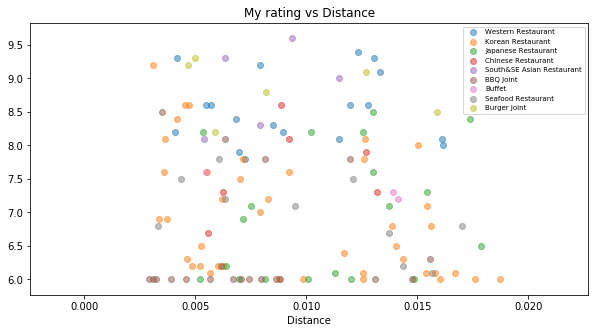

In [132]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
for t in df_to_plot.New_categories.unique():
    x = df_to_plot.loc[df_to_plot.New_categories == t,'distance']
    y = df_to_plot.loc[df_to_plot.New_categories == t,'User_rating']

    ax.scatter(x,y,alpha = 0.5,label = t)
ax.set_title('My rating vs Distance')
ax.set_xlabel('Distance')
ax.legend(fontsize = 7)

plt.show()

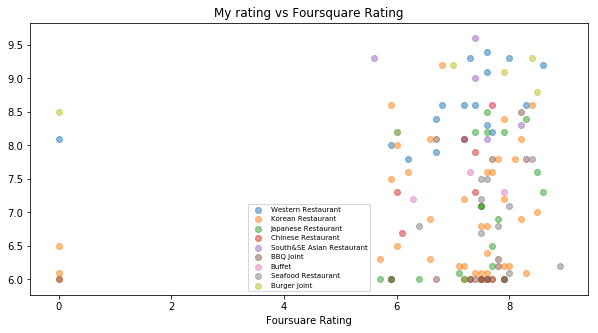

In [135]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
for t in df_to_plot.New_categories.unique():
    x = df_to_plot.loc[df_to_plot.New_categories == t,'rating']
    y = df_to_plot.loc[df_to_plot.New_categories == t,'User_rating']

    ax.scatter(x,y,alpha = 0.5,label = t)
ax.set_title('My rating vs Foursquare Rating')
ax.set_xlabel('Foursuare Rating')
ax.legend(fontsize = 7)

plt.show()

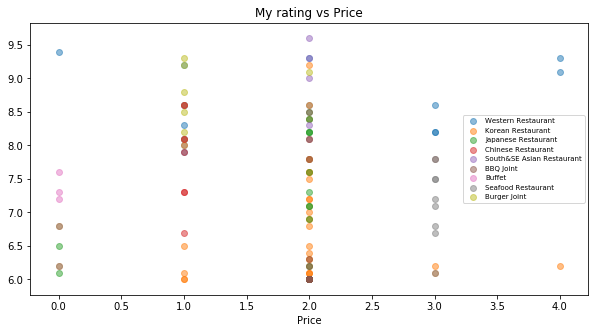

In [139]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
for t in df_to_plot.New_categories.unique():
    x = df_to_plot.loc[df_to_plot.New_categories == t,'price']
    y = df_to_plot.loc[df_to_plot.New_categories == t,'User_rating']

    ax.scatter(x,y,alpha = 0.5,label = t)
ax.set_title('My rating vs Price')
ax.set_xlabel('Price')
ax.legend(fontsize = 7)

plt.show()

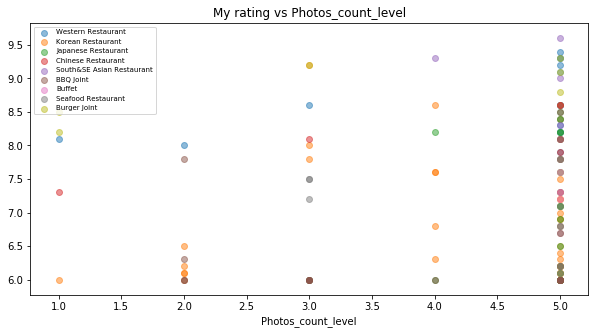

In [142]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
for t in df_to_plot.New_categories.unique():
    x = df_to_plot.loc[df_to_plot.New_categories == t,'Photos_count_level']
    y = df_to_plot.loc[df_to_plot.New_categories == t,'User_rating']

    ax.scatter(x,y,alpha = 0.5,label = t)
ax.set_title('My rating vs Photos_count_level')
ax.set_xlabel('Photos_count_level')
ax.legend(fontsize = 7)

plt.show()

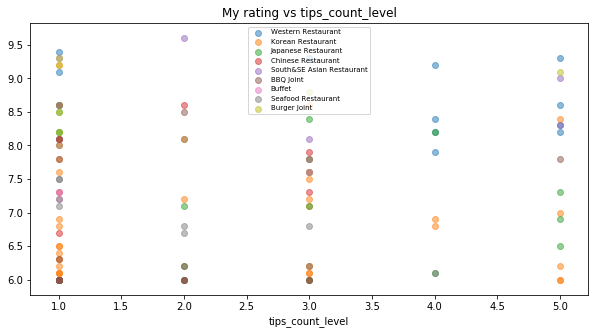

In [143]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
for t in df_to_plot.New_categories.unique():
    x = df_to_plot.loc[df_to_plot.New_categories == t,'tips_count_level']
    y = df_to_plot.loc[df_to_plot.New_categories == t,'User_rating']

    ax.scatter(x,y,alpha = 0.5,label = t)
ax.set_title('My rating vs tips_count_level')
ax.set_xlabel('tips_count_level')
ax.legend(fontsize = 7)

plt.show()

일단 별다른 drop 없이 feature를 머신러닝에 사용하기로 함. 0번부터 44번까지가 역삼역 인근 데이터임 

In [147]:
df_features_with_rating.columns

Index(['name', 'categories', 'lat', 'lng', 'id', 'Station', 'New_categories',
       'distance', 'price', 'rating', 'photos_count', 'tips_count',
       'Photos_count_level', 'tips_count_level', 'User_rating'],
      dtype='object')

In [153]:
df_features_with_rating_drop = df_features_with_rating.drop(columns=['name',
                                                                     'categories',
                                                                     'lat','lng',
                                                                     'Station',
                                                                     'photos_count',
                                                                     'tips_count'])

In [154]:
df_New_categories_onehot = pd.get_dummies(df_features_with_rating[['New_categories']], prefix="", prefix_sep="")
df_New_categories_onehot['id'] = df_features_with_rating['id']

In [160]:
df_features_with_rating_with_onehot = pd.merge(df_New_categories_onehot,
                                               df_features_with_rating_drop,on = 'id').drop(columns = ['id','New_categories'])

In [162]:
df_features_with_rating_with_onehot.head()

,BBQ Joint,Buffet,Burger Joint,Chinese Restaurant,Japanese Restaurant,Korean Restaurant,Seafood Restaurant,South&SE Asian Restaurant,Western Restaurant,distance,price,rating,Photos_count_level,tips_count_level,User_rating
0,0,0,0,1,0,0,0,0,0,0.010907,1.0,8.0,5.0,3.0,0.0
1,1,0,0,0,0,0,0,0,0,0.010252,2.0,8.3,5.0,3.0,0.0
2,0,0,0,0,0,1,0,0,0,0.009911,2.0,8.4,5.0,3.0,0.0
3,0,0,1,0,0,0,0,0,0,0.008299,1.0,8.0,4.0,2.0,0.0
4,0,0,0,0,0,1,0,0,0,0.010933,2.0,8.2,5.0,4.0,0.0


In [193]:
X = df_features_with_rating_with_onehot.drop(columns=['User_rating'])
Y = df_features_with_rating_with_onehot.loc[:,'User_rating']

In [194]:
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
X = standardscaler.fit_transform(X)

In [195]:
data_to_predict = pd.DataFrame(X).iloc[0:45]
data_to_learning = pd.DataFrame(X).iloc[45:]

In [196]:
answer_of_learning = Y.iloc[45:]

In [197]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_to_learning,answer_of_learning, test_size=0.3, random_state=0)

In [201]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

## K Nearest Neighbor(KNN)

In [214]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [209]:
neigh = KNeighborsRegressor(n_neighbors = 7).fit(train_x,train_y)
yhat=neigh.predict(test_x)
rmse_val = []

array([1.24285714, 1.0547619 , 1.08651911, 1.01045296, 0.83554817,
       0.8956044 , 1.17380952, 0.83392857, 0.8915009 , 1.20276498,
       1.01162791, 0.95008606, 1.05467372, 1.14761905, 1.01530612,
       1.14976959, 1.0931677 , 0.99319728, 0.86378738, 0.9906015 ,
       1.09285714, 1.01318681, 0.97744361, 1.00420168, 1.05      ,
       1.17741935, 1.14047619, 0.82291667, 1.19672131, 0.98684211,
       0.74453782, 1.25952381, 1.13348946, 1.24285714, 0.95676692,
       1.22857143, 0.95238095, 1.0547619 , 1.05226481])

In [237]:
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsRegressor(n_neighbors = n).fit(train_x,train_y)
    yhat=neigh.predict(test_x)
    error = sqrt(mean_squared_error(test_y,yhat))
    mean_acc[n-1] = error
    
    #std_acc[n-1]=np.std(yhat==test_y)/np.sqrt(yhat.shape[0])

mean_acc

array([1.18840553, 0.99431074, 0.9653395 , 0.89971505, 0.90246386,
       0.90956065, 0.9240776 , 0.94852703, 0.94749466, 0.94711573,
       0.94458338, 0.91774897, 0.929003  , 0.92491956, 0.92220904,
       0.93506414, 0.95343218, 0.95459022, 0.95409704, 0.95596675,
       0.96737976, 0.98153378, 0.97992154, 0.97712644, 0.96951227,
       0.97400304, 0.97149699, 0.96375749, 0.96591267])

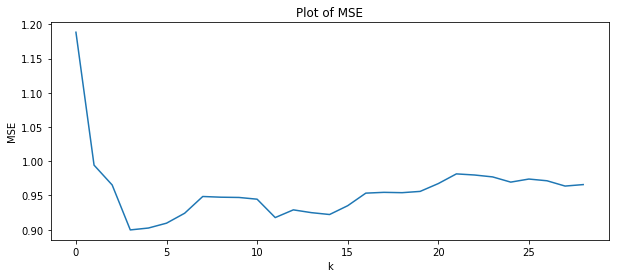

In [5]:
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(111)
y = mean_acc
ax.plot(y)
ax.set_title('Plot of MSE')
ax.set_xlabel('k')
ax.set_ylabel('MSE')
plt.show()

pick k = 5 

In [220]:
neigh_5 = KNeighborsRegressor(n_neighbors = 5).fit(data_to_learning,answer_of_learning)
yhat_5=neigh.predict(data_to_predict)

In [221]:
yhat_5

array([7.09473684, 6.68421053, 6.97894737, 7.76842105, 6.97894737,
       6.63157895, 7.15789474, 6.94736842, 7.03684211, 8.02631579,
       7.43684211, 6.56315789, 7.12631579, 7.57368421, 8.06315789,
       6.47894737, 6.54736842, 7.18421053, 6.92631579, 7.11052632,
       7.12105263, 6.56315789, 7.27894737, 7.41578947, 6.68421053,
       7.07368421, 7.18947368, 7.06315789, 7.19473684, 6.93157895,
       8.12631579, 7.35263158, 7.32631579, 6.98421053, 6.75263158,
       7.28421053, 7.15789474, 7.16315789, 7.17368421, 6.94736842,
       7.17368421, 7.01578947, 7.02631579, 7.25263158, 6.83684211])

In [224]:
column_filter= ['name','lat','lng','New_categories']
Restaurant_Yeoksam = df_features.loc[df_features.Station == 'Yeoksam',column_filter]
Restaurant_Yeoksam['KNN_rating'] = yhat_5

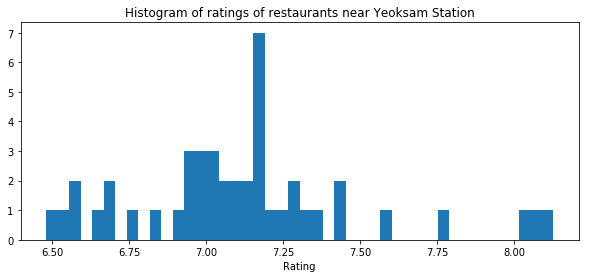

In [7]:
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(111)
y = yhat_5
ax.hist(y,bins = 44)
ax.set_title('Histogram of ratings of restaurants near Yeoksam Station')
ax.set_xlabel('Rating')
plt.show()

## Result  

I predict ratings of restaurants near Yeoksam station, using KNN Regressor Model which k as 4. Drawing a histogram of Ratings can know that most places’ rating is between 6.8~7.3. I filte the restaurants which predict rating is higher than 7.25, add markers to map. 

The result is similar to what I find during EDA, high score restaurants including Western restaurants, and Burger joints and Japanese Restaurants. So the outcome of this machine learning is, If I go to Yeaksam station to have lunch, I can select the lunch point between makers on the map. 

In [234]:
rate = 7.25
rating_filter = Restaurant_Yeoksam.loc[Restaurant_Yeoksam.KNN_rating >= rate,]

map_gangnam = folium.Map(location=[office_lat, office_lng], zoom_start=15)

for lat, lng, borough, neighborhood in zip(rating_filter['lat'], rating_filter['lng'], 
                                           rating_filter['name'], rating_filter['New_categories']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gangnam) 

    
folium.CircleMarker(
        [office_lat, office_lng],
        radius=6,
        popup='office',
        color='red',
        fill=False,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gangnam) 


map_gangnam

## Discussion 
After making this adviser, I think I can select other places to know where I’m going to eat. But I also worried about someone who loves every food not like me don’t prefer to eat Korean food at lunch will be more difficult to recommend restaurants. Then categories is a not important feature for machine learning, maybe the Collaborative Filtering mentioned in the course of Machine Learning with Python in Coursera will be a good solution. 

##  Conclusion 
This project let me get an adviser which can recommend restaurants for me. It learned my tastes and predict ratings of restaurants. This is my first machine learning project which I choose the topic myself, collected data myself, analyzed myself. It must be many incorrect in the process. If I go to the new place like Fukuoka in Japan or Beijing in China, this first version of the algorithm may not work well, but I believe it will give me more insight of what I to complement. I will keep exploring new places! 
